In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
from PIL import Image
import pipeline
import tensorflow as tf

In [2]:
dataset = pipeline.Pipeline(file='CDStent.raw').dataset #création de notre dataset
x = []
y = []
for noised_images, labels in dataset:
        x.append(noised_images.numpy())
        y.append(labels.numpy())

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

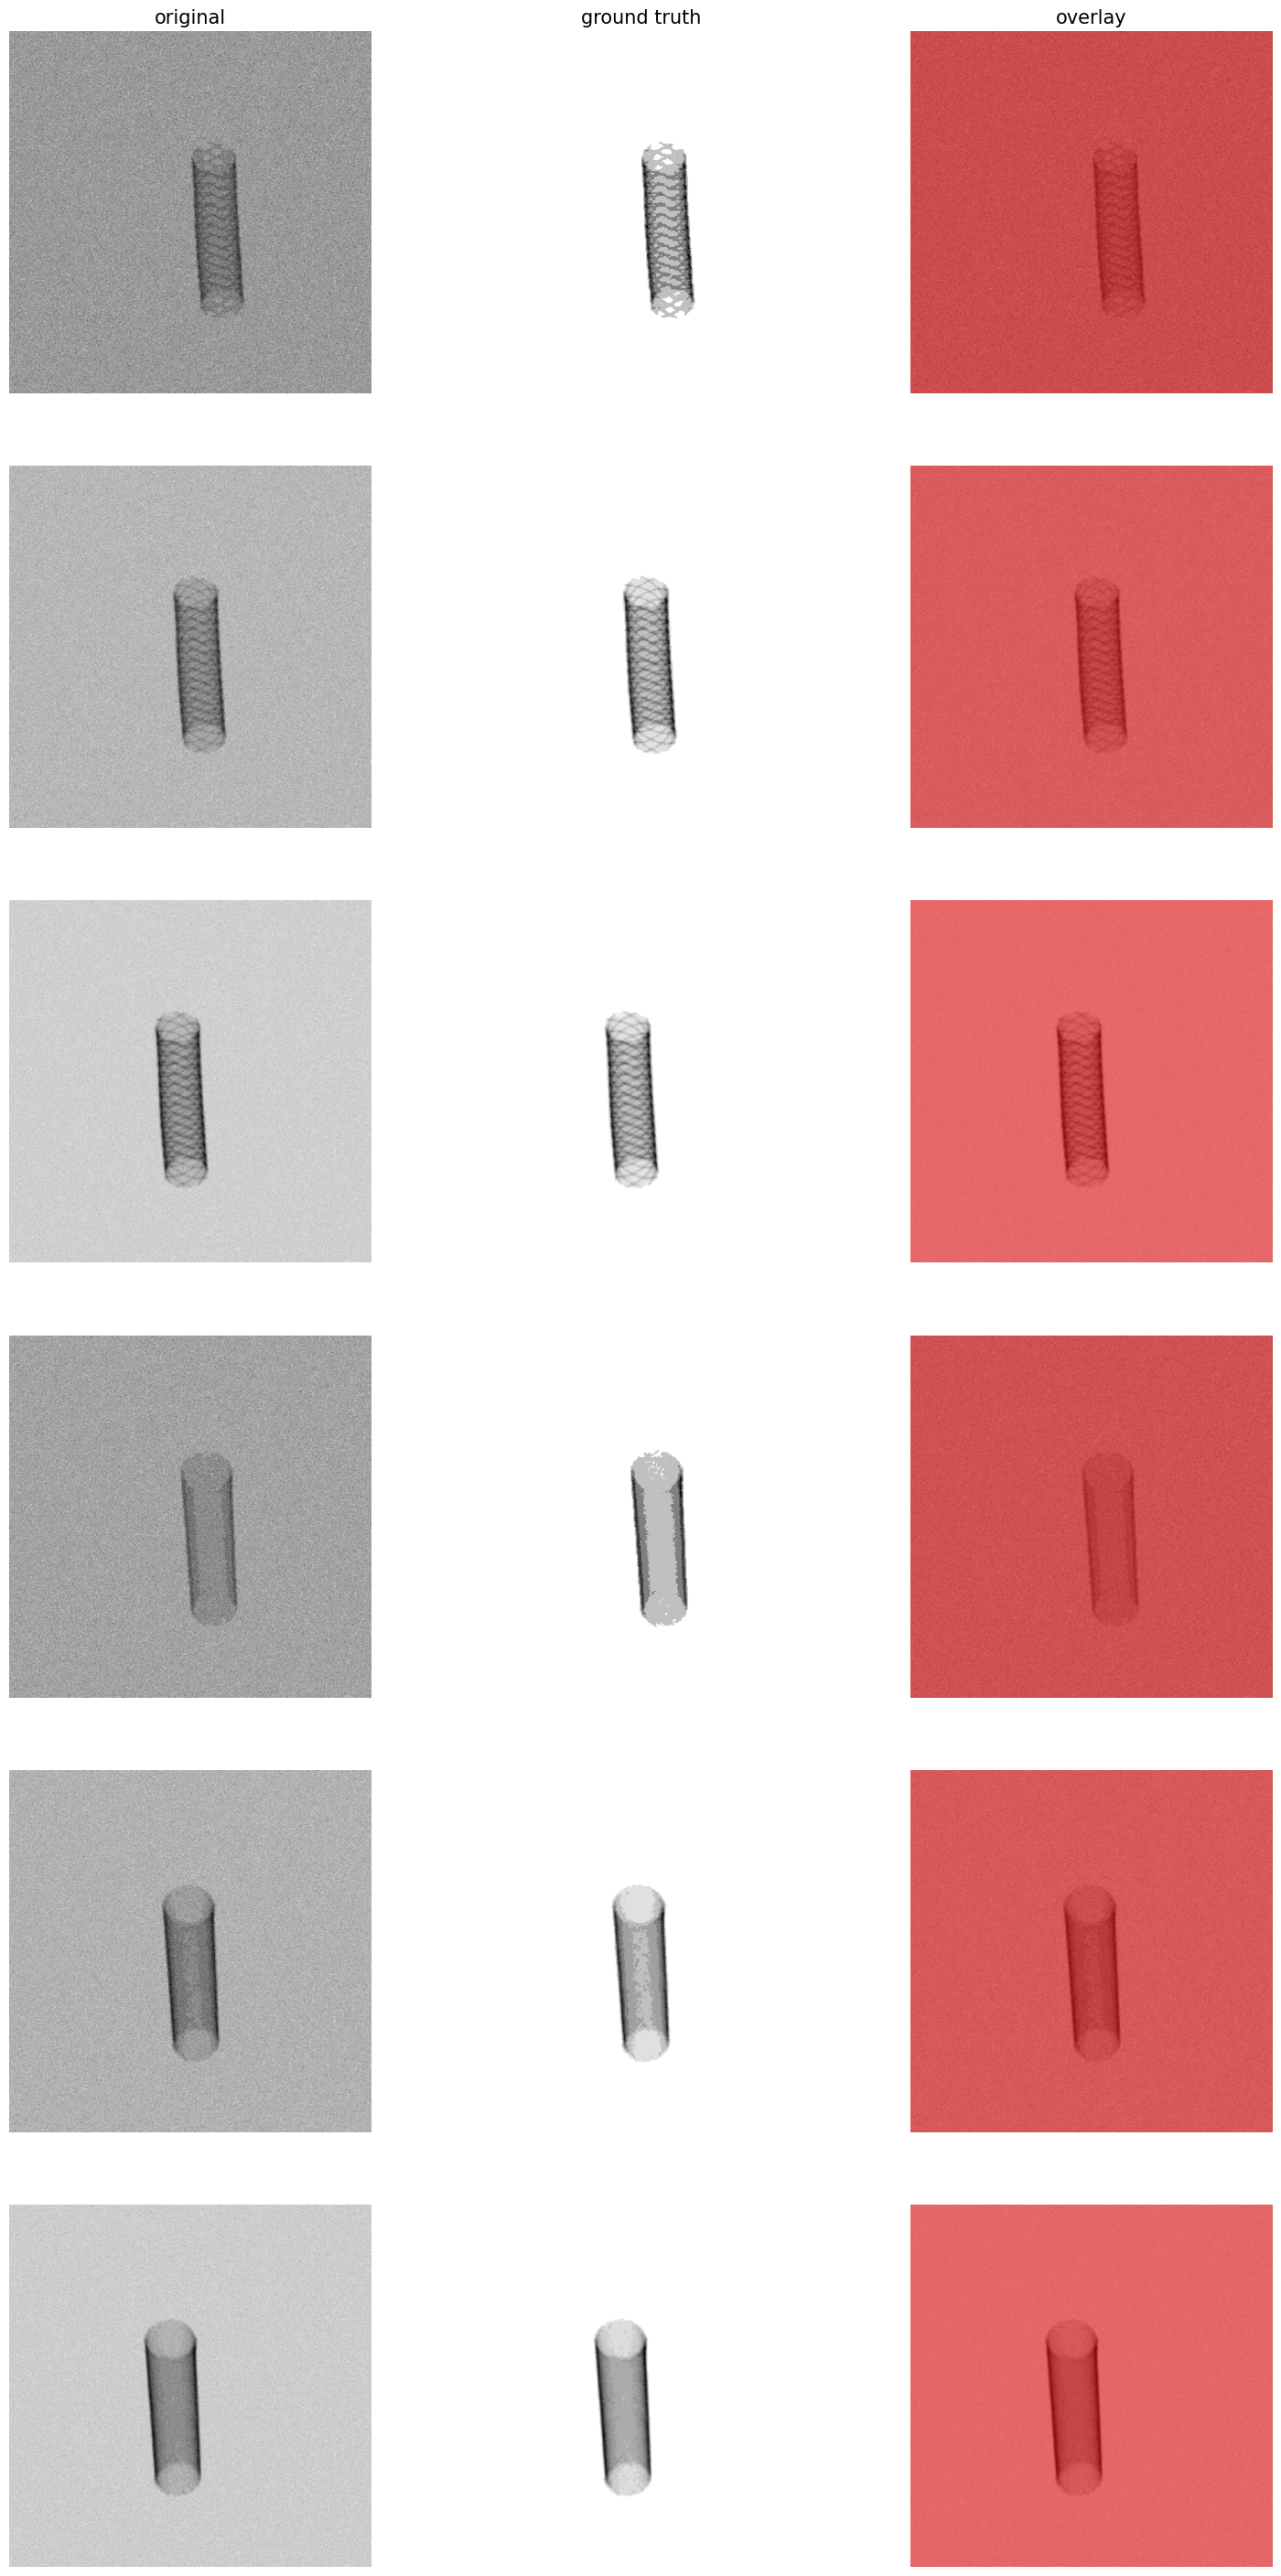

In [3]:
from utils import plot_imgs
plot_imgs(org_imgs=x, mask_imgs=y, nm_img_to_plot=6, figsize=6)

##  Train/val split

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5, random_state=42)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (405, 512, 512, 1)
y_train:  (405, 512, 512, 1)
x_val:  (405, 512, 512, 1)
y_val:  (405, 512, 512, 1)


## Prepare train generator with data augmentation

In [5]:
from utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=3,
    data_gen_args = dict(
        rotation_range=10.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        # fill_mode='nearest'
    ))

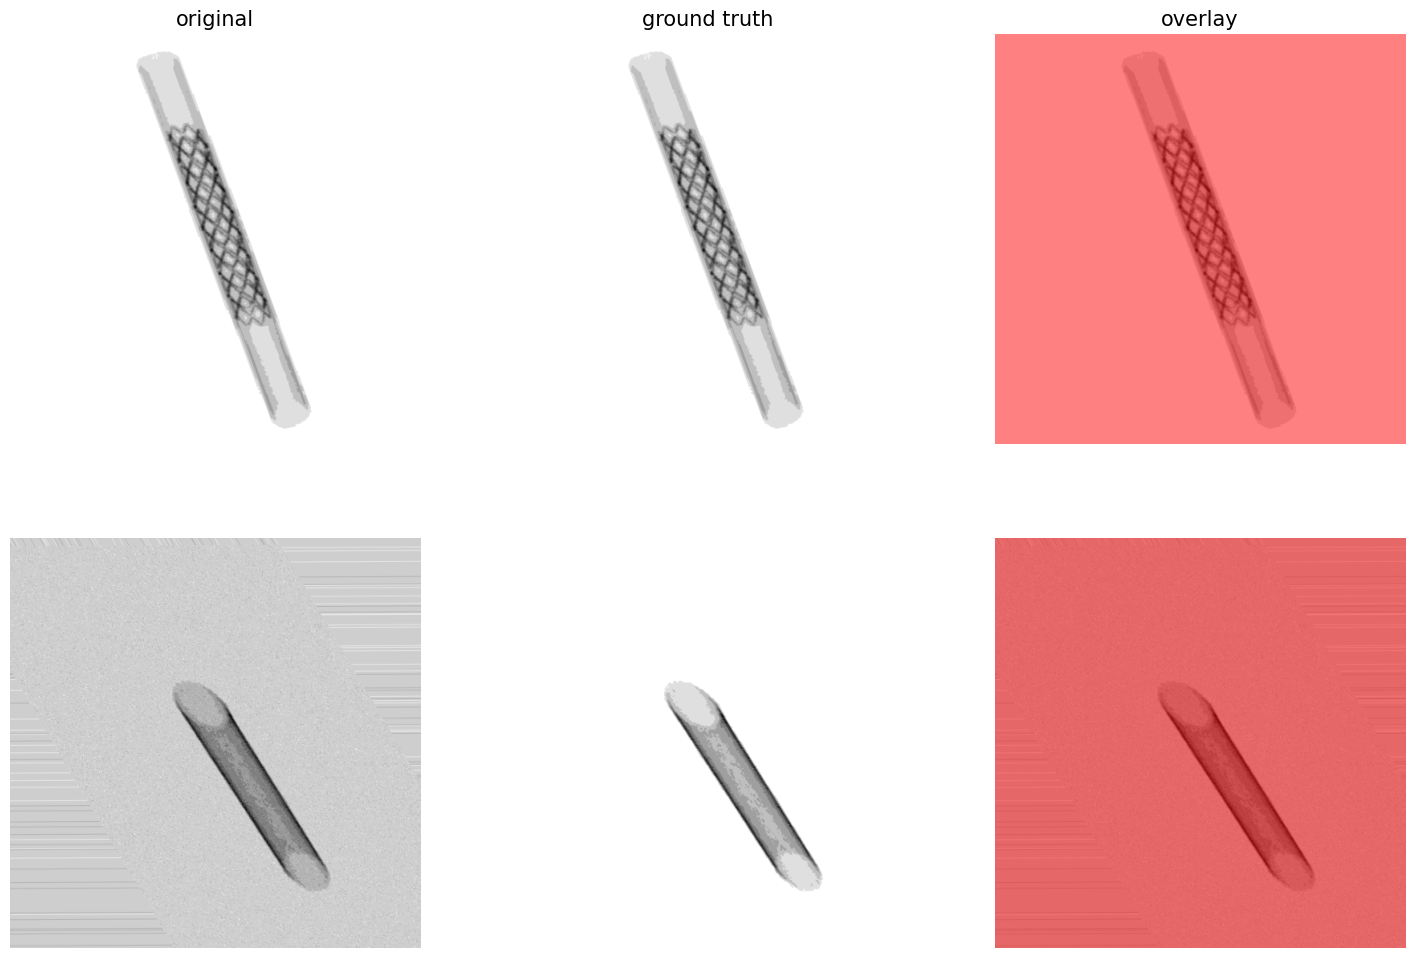

In [6]:
sample_batch = next(train_gen)
xx, yy = sample_batch
plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

## Initialize network

In [9]:
from unet import unet_model
input_shape = x_train[0].shape

model = unet_model(input_shape)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [12]:
# from utils import plot_model
# plot_model(model, to_file='model.png')

## Compile + train

In [13]:
from keras.callbacks import ModelCheckpoint
model_filename = 'model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', #pas besoin de modifier, cette fonction prend la loss fixée par model.compile
    save_best_only=True,
)

In [14]:
from keras.optimizers import Adam, SGD
from metrics import iou, iou_thresholded
from losses import jaccard_distance
# from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.metrics import mean_absolute_error, mean_squared_error

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='MSE', 
    metrics=[mean_squared_error, mean_absolute_error] 
)


In [15]:
history = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint])

Epoch 1/10
  6/100 [>.............................] - ETA: 10:21 - loss: 4.9949 - mean_squared_error: 4.9949 - mean_absolute_error: 1.4599

KeyboardInterrupt: 

## Plot training history

In [ ]:
from utils import plot_segm_history

plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [ ]:
# model.load_weights(model_filename)
y_pred = model.predict(x_val)
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)

In [ ]:
for i in range(10):
  denoised_image = model.predict(np.expand_dims(x_val[i], axis=0))[0]

  # Post-traitement de l'image débruitée
  denoised_image = denoised_image * 255.
  denoised_image = np.clip(denoised_image, 0, 255)
  denoised_image = denoised_image.astype(np.uint8)
  plt.imshow(denoised_image,cmap='gray'),plt.show()